# Federated Learning (FL) - Titanic

## Objective
Train an ML model of your choice to predict the survival probability in a federated setup and benchmark it against a model being trained on the full dataset.


## Import packages

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from pathlib import Path

In [101]:
# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# pandas show full output
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 200)

# add module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
from src import config
from src import client
from src import data
from src import preprocess
from src import model
from src import server
from src import stats
from src import visual
from src import utils

In [103]:
from sklearn.linear_model import SGDClassifier

## Set-up server
The server contains one or more colloborations. It orchestrates the movement of algorithms between clients and the aggregation of the results.

Here we initialize a Server set up for the Titanic use case. All algorithms part of the Server's collaboration are distributed to each respective client.

In [120]:
server_titanic = config.ServerTitanic()
server_titanic

All algorithms are distributed to clients successfully


ServerTitanic(
       collab=CollaborationTitanic()
)

A collaboration consists of:
1. clients: data owners
2. statistics: statistical functions 
3. transformers: transformer pipeline to pre-process the data prior to training the classifier
4. classsifer: classifier trained on local datasets
5. classifier_aggregator: strategy to combine classifier results
6. statistics_aggregators: methods to combine statistical results

In [105]:
server_titanic.collab

CollaborationTitanic(
       clients=[ClientA(), ClientB()], 
       statistics={count_records=CountRecords(), nominal_categories=ColumnCategories(), target_classes=ColumnCategories()}, 
       transformers=Pipeline(), 
       classifier=BatchSGD(), 
       classifier_aggregator=FedAvg(), 
       statistics_aggregators={count_records=SumValues(), nominal_categories=NestedListUnion(), target_classes=ListUnion()}
)

Clients have a pointer to the data they have stored locally. They also store a local version of all algorithms defined in the collab and can run these on their local data.

In [55]:
server_titanic.collab.clients[0]

ClientA(
       name=A, 
       data_pointer=DataA(), 
       clf_local=BatchSGD(), 
       transformers=Pipeline(), 
       statistics={count_records=CountRecords(), nominal_categories=ColumnCategories(), target_classes=ColumnCategories()}, 
       clf_scores_={clf_scores_={'local_scores': [], 'global_scores': []}, clf_scores_={'local_scores': [], 'global_scores': []}}, 
       clf_results_={}
)

## Run statistics

The following statistics are run on the local datasets. These statistics can give a summary of the data, but are also used in the next section to define parameter in the transformer pipeline and classifier aggregation strategy.
- count_records: used to set the weights of the classifier aggregation, to give more weight to updates from clients that trained their data on larger datasets.
- nominal_categories: merges all column categories in the nominal columns of all client's datasets, where each local dataset might have distinct categories. This information can be used by a one-hot-encoding step in the transformer pipeline to ensure columns are created for all possible categories.
- target_classes: merges all possible target classes to ensure that both clients have all possible targets to be predicted.

In [56]:
server_titanic.collab.statistics

{'count_records': CountRecords(),
 'nominal_categories': ColumnCategories(
        column_names=[Sex, Embarked], 
        flatten_list=False
 ),
 'target_classes': ColumnCategories(
        column_names=[Survived], 
        flatten_list=True
 )}

It uses the following strategies to combine the local statistic results, to get a statistics of the combined data.

In [57]:
server_titanic.collab.statistics_aggregators

{'count_records': SumValues(),
 'nominal_categories': NestedListUnion(
        unique=True
 ),
 'target_classes': ListUnion(
        unique=True
 )}

Using the following function, the servers orders all clients to run the statistical methods on their local data and subsequently aggregates them.

In [58]:
server_titanic.run_statistics()

ServerTitanic(
       collab=CollaborationTitanic()
)

This way we inspect the local statistic results, for example a count of the number of records for the data provided by each client.

In [59]:
server_titanic.collab.clients[0].statistics['count_records']

CountRecords(
       results_=244
)

In [60]:
server_titanic.collab.clients[1].statistics['count_records']

CountRecords(
       results_=468
)

And here we see the combined results, when summing the number of records for all clients.

In [61]:
server_titanic.collab.statistics['count_records']

CountRecords(
       results_=712
)

## Train Federated Classifier

The server can order all clients to transform their data and train their classifier locally. It uses the following transformer pipeline and classifier.

In [62]:
server_titanic.collab.transformers

Pipeline(steps=[('preprocess',
                 GenericPreprocessor(features_continuous=['Age', 'Fare'],
                                     features_drop=['PassengerId', 'pred',
                                                    'Name', 'Ticket', 'Cabin'],
                                     features_nominal=['Sex', 'Embarked'],
                                     features_ordinal=['Pclass', 'SibSp',
                                                       'Parch'])),
                ('scale', RobustScaler())])

BatchSGD is a subclass of the sklearn SGDCLassifier, which can use stochastic gradient descent to train on batches of data instead of single examples. The loss parameter allows the user to select different classifiers, for example a logistic regression (using 'log_loss') or linear SVM (using 'hinge').

In [63]:
server_titanic.collab.classifier

BatchSGD(batch_size=20, loss='log_loss', n_local_iterations=100,
         random_state=42)

In [121]:
server_titanic.fit_classifier()

Thie above function automatically averages the results using the strategy below. Note the weights are derived from the 'count_records' statistic computed earlier.

In [65]:
server_titanic.collab.classifier_aggregator

FedAvg(
       n_iterations=20, 
       weights=[0.34269663 0.65730337]
)

## Training a centralized model
For comparison, we also train a centralized model with the same configurations as specified in the Federated set-up, but where we first combine the data from each client and then train a classifier.

In [67]:
def combine_dataset():
    # load data files of each party
    data_a = config.DataA()
    X_train_a, y_train_a = data_a.load_train_data(split_xy=True)
    X_test_a, y_test_a = data_a.load_test_data(split_xy=True)

    data_b = config.DataB()
    X_train_b, y_train_b = data_b.load_train_data(split_xy=True)
    X_test_b, y_test_b = data_b.load_test_data(split_xy=True)

    # join data files
    X_train = pd.concat([X_train_a, X_train_b])
    X_test = pd.concat([X_test_a, X_test_b])
    y_train = pd.concat([y_train_a, y_train_b])
    y_test = pd.concat([y_test_a, y_test_b])

    return X_train, X_test, y_train, y_test

def train_centralized_model(X_train, y_train, X_test, y_test):
    """Train model when data is first is centralized (i.e. combined)"""

    # load transformer pipeline and classifier 
    pipeline = model.get_standard_transformer_pipeline(features_drop=config.FEATURES_DROP,
                                                       features_nominal=config.FEATURES_NOMINAL,
                                                       features_ordinal=config.FEATURES_ORDINAL,
                                                       features_continuous=config.FEATURES_INTERVAL+config.FEATURES_RANGE, 
                                                       categories='auto')
    classifier = model.get_standard_classifier(random_state=config.RANDOM_STATE)

    # merge classifier to pipeline
    pipeline.steps.append(('clf', classifier))
    
    # train model store scores each iteration
    scores = []
    for n in range(config.N_GLOBAL_ITERATIONS):
        pipeline.fit(X_train, y_train)
        scores.append(pipeline.score(X_test, y_test))
    return pipeline, scores


X_train, X_test, y_train, y_test = combine_dataset()
clf_central, scores_central = train_centralized_model(X_train, y_train, X_test, y_test)

## Evaluate results

Before comparing the results, we first need to run the following function for the server to order each client to perform some evaluation steps

In [122]:
server_titanic.evaluate_classifier()

In [123]:
server_titanic.collab.clf_results_

{'A': {'accuracy': 0.7903225806451613,
  'roc_auc_score': 0.7761904761904761,
  'average_precision': 0.690615835777126,
  'confusion_matrix': array([[31,  4],
         [ 9, 18]], dtype=int64)},
 'B': {'accuracy': 0.8034188034188035,
  'roc_auc_score': 0.7261904761904762,
  'average_precision': 0.648962148962149,
  'confusion_matrix': array([[75,  0],
         [23, 19]], dtype=int64)}}

In [115]:
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, accuracy_score

In [124]:
y_pred = clf_central.predict(X_test)
print(f'accuracy score centralized: {accuracy_score(y_test, y_pred)}')
print(f'roc auc score centralized: {roc_auc_score(y_test, y_pred)}')
print(f'average precision score centralized: {average_precision_score(y_test, y_pred)}')

accuracy score centralized: 0.7877094972067039
roc auc score centralized: 0.7678524374176547
average precision score centralized: 0.6310715795777734


We can get the scores from the server and merge these with the scores from the centralized model for comparison

In [125]:
df_classifier_scores = server_titanic.collab.merge_classifier_scores(output_df=True)
df_classifier_scores['Centralized'] = scores_central
df_classifier_scores.head()

,A.local_scores,A.global_scores,B.local_scores,B.global_scores,Centralized
0,0.709677,0,0.803419,0,0.770950
1,0.725806,0.790323,0.811966,0.74359,0.793296
2,0.709677,0.693548,0.803419,0.794872,0.776536
3,0.725806,0.709677,0.717949,0.735043,0.765363
4,0.774194,0.774194,0.786325,0.735043,0.776536


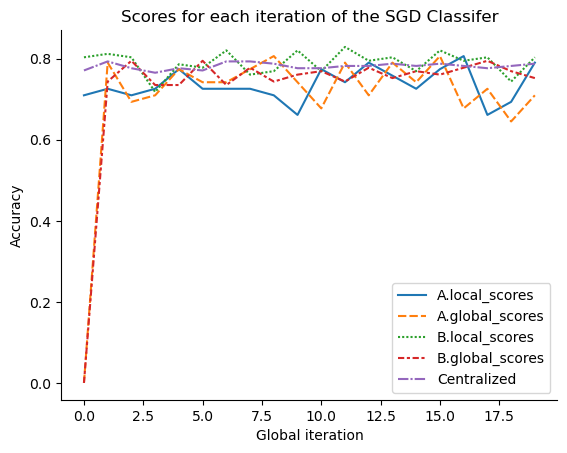

In [126]:
ax = sns.lineplot(df_classifier_scores)
sns.despine()
ax.set_xlabel('Global iteration')
ax.set_ylabel('Accuracy')
ax.set_title('Scores for each iteration of the SGD Classifer')
plt.show()

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

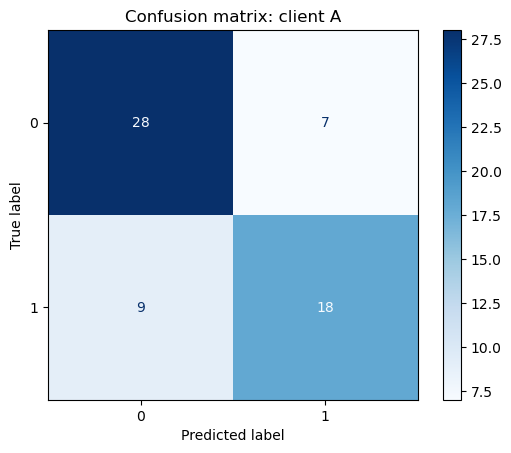

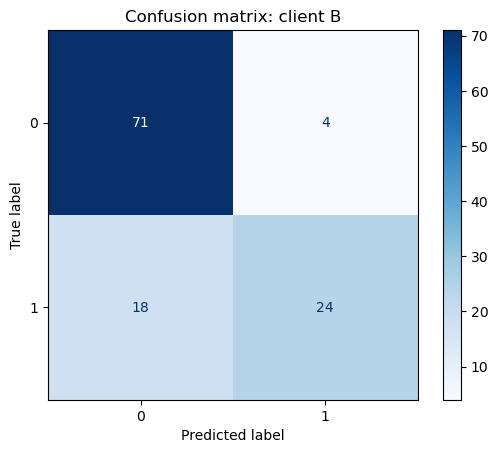

In [84]:
for client_name, results in server_titanic.collab.clf_results_.items():
    cmd = visual.plot_confusion_matrix(results['confusion_matrix'])
    plt.title(f'Confusion matrix: client {client_name}')


Text(0.5, 1.0, 'Confusion matrix: centralized model')

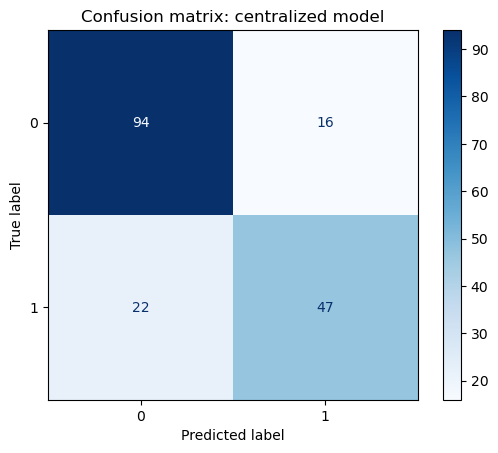

In [88]:
y_pred_central = clf_central.predict(X_test)
cm_central = confusion_matrix(y_test, y_pred_central)
visual.plot_confusion_matrix(cm_central)
plt.title('Confusion matrix: centralized model')

## Test whether pipeline works on unseen data

In [91]:
df_test_unlabeled = preprocess.load_unlabeled_test_data()
df_test_unlabeled.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


For now we don't have a way to merge fitted transformer pipelines between clients, thus we need to get one transformer from one of the clients.

In [94]:
df_test_unlabeled_transformed = server_titanic.collab.clients[0].transformers.transform(df_test_unlabeled)
server_titanic.collab.classifier.predict(df_test_unlabeled_transformed)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [92]:
clf_central.predict(df_test_unlabeled)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## Archive

In [216]:
# del score_dict['A']['global']
# del score_dict['B']['global']

In [6]:
# score_dict2 = {'A': score_dict['A']['local'], 'B': score_dict['B']['local']}
# df_score_dict = pd.DataFrame().from_dict(score_dict2)
# df_score_dict.head()


In [218]:
# df_score_dict = pd.json_normalize(score_dict).apply(pd.Series.explode).reset_index(drop=True)
# df_score_dict.head()

,A.local,B.local
0,0.629032,0.786325
1,0.725806,0.820513
2,0.709677,0.803419
3,0.725806,0.803419
4,0.725806,0.786325


In [ ]:
df_score_dict.shape

In [152]:
server_titanic.collab.classifier_aggregator.weights

array([0.34269663, 0.65730337])

In [158]:
server_titanic.collab.clients[1].statistics['count_records'].results_

468

<AxesSubplot:>

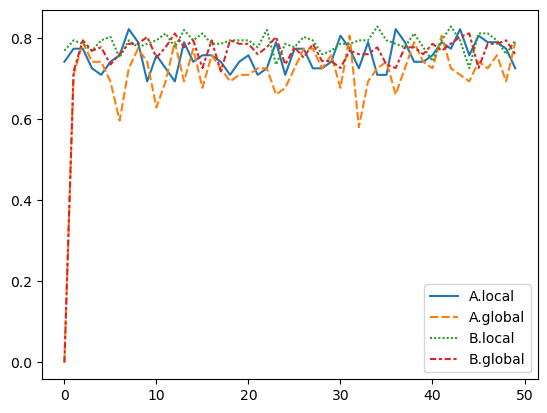

In [90]:
server_titanic.collab
sns.lineplot(df_score_dict)

In [95]:
client_a = config.ClientA()
client_b = config.ClientB()

client_a._run_transformers()

AttributeError: 'NoneType' object has no attribute 'fit_transform'

In [105]:
X_train = pd.concat([X_train_a, X_train_b])
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,622,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,S
1,220,2,"Harris, Mr. Walter",male,30.0,0,0,W/C 14208,10.5000,NaN,S
2,229,2,"Fahlstrom, Mr. Arne Jonas",male,18.0,0,0,236171,13.0000,NaN,S
3,169,1,"Baumann, Mr. John D",male,NaN,0,0,PC 17318,25.9250,NaN,S
4,408,2,"Richards, Master. William Rowe",male,3.0,1,1,29106,18.7500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
239,673,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,S
240,453,1,"Foreman, Mr. Benjamin Laventall",male,30.0,0,0,113051,27.7500,C111,C
241,713,1,"Taylor, Mr. Elmer Zebley",male,48.0,1,0,19996,52.0000,C126,S
242,345,2,"Fox, Mr. Stanley Hubert",male,36.0,0,0,229236,13.0000,NaN,S


In [162]:
X_train_a.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,622,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,S
1,220,2,"Harris, Mr. Walter",male,30.0,0,0,W/C 14208,10.5000,NaN,S
2,229,2,"Fahlstrom, Mr. Arne Jonas",male,18.0,0,0,236171,13.0000,NaN,S
3,169,1,"Baumann, Mr. John D",male,NaN,0,0,PC 17318,25.9250,NaN,S
4,408,2,"Richards, Master. William Rowe",male,3.0,1,1,29106,18.7500,NaN,S


In [18]:
scores_centralized = train_centralized_model()

In [15]:
df_score_dict = server_titanic.collab.merge_collab_scores(output_df=True)
df_score_dict['Centralized'] = scores

<AxesSubplot:>

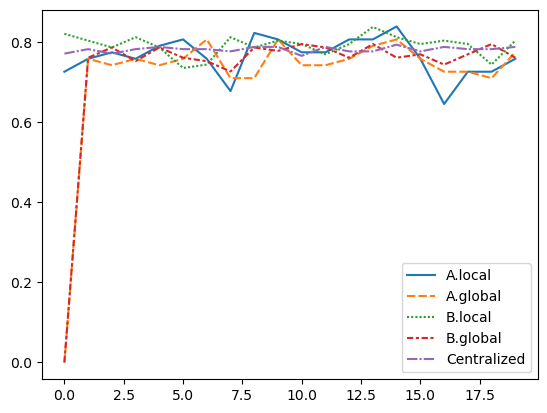

In [25]:
sns.lineplot(df_score_dict)

In [ ]:
model.get_standard_classifier(random_state=config.RANDOM_STATE)

<AxesSubplot:>

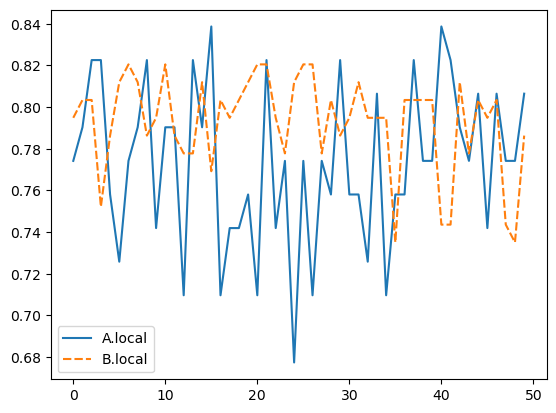

In [74]:
server_titanic.collab
sns.lineplot(df_score_dict[['A.local', 'B.local']])

In [62]:
server_titanic.collab.merge_collab_scores()
server_titanic.collab.scores_

{'A': {'local': [0.7741935483870968,
   0.7903225806451613,
   0.8225806451612904,
   0.8225806451612904,
   0.7580645161290323,
   0.7258064516129032,
   0.7741935483870968,
   0.7903225806451613,
   0.8225806451612904,
   0.7419354838709677,
   0.7903225806451613,
   0.7903225806451613,
   0.7096774193548387,
   0.8225806451612904,
   0.7903225806451613,
   0.8387096774193549,
   0.7096774193548387,
   0.7419354838709677,
   0.7419354838709677,
   0.7580645161290323,
   0.7096774193548387,
   0.8225806451612904,
   0.7419354838709677,
   0.7741935483870968,
   0.6774193548387096,
   0.7741935483870968,
   0.7096774193548387,
   0.7741935483870968,
   0.7580645161290323,
   0.8225806451612904,
   0.7580645161290323,
   0.7580645161290323,
   0.7258064516129032,
   0.8064516129032258,
   0.7096774193548387,
   0.7580645161290323,
   0.7580645161290323,
   0.8225806451612904,
   0.7741935483870968,
   0.7741935483870968,
   0.8387096774193549,
   0.8225806451612904,
   0.790322580645161

In [248]:
server_titanic.collab.merge_collab_scores()
server_titanic.collab.scores_

{'A': {'local': [0.6774193548387096,
   0.8387096774193549,
   0.8225806451612904,
   0.8225806451612904,
   0.8064516129032258,
   0.7903225806451613,
   0.7903225806451613,
   0.7741935483870968,
   0.7580645161290323,
   0.7580645161290323],
  'global': [0,
   0.6612903225806451,
   0.7419354838709677,
   0.7419354838709677,
   0.7419354838709677,
   0.7903225806451613,
   0.7741935483870968,
   0.7258064516129032,
   0.7419354838709677,
   0.7741935483870968]},
 'B': {'local': [0.8034188034188035,
   0.8034188034188035,
   0.7948717948717948,
   0.7863247863247863,
   0.7777777777777778,
   0.7863247863247863,
   0.7948717948717948,
   0.811965811965812,
   0.7692307692307693,
   0.7948717948717948],
  'global': [0,
   0.7863247863247863,
   0.7863247863247863,
   0.7863247863247863,
   0.7692307692307693,
   0.7521367521367521,
   0.7863247863247863,
   0.7863247863247863,
   0.7606837606837606,
   0.7606837606837606]}}

In [243]:
server_titanic.collab.clients[0].local_scores_

[0.6774193548387096,
 0.8387096774193549,
 0.8225806451612904,
 0.8225806451612904,
 0.8064516129032258,
 0.7903225806451613,
 0.7903225806451613,
 0.7741935483870968,
 0.7580645161290323,
 0.7580645161290323]

In [235]:
server_titanic.collab.clients[0].global_scores_

[0,
 0.7258064516129032,
 0.7419354838709677,
 0.7741935483870968,
 0.7419354838709677,
 0.7258064516129032,
 0.7580645161290323,
 0.7580645161290323,
 0.7580645161290323,
 0.7096774193548387]

In [157]:
X_train, X_test, y_train, y_test = server_titanic._run_transformers(server_titanic.collab.clients[0])

In [158]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)

SGDClassifier()

In [188]:
np.array([c for c in [[0,1],[0,1]]]).flat()

TypeError: 'numpy.flatiter' object is not callable

In [147]:
server_titanic.collab.clients[0].clf_local

SGDClassifier(loss='log_loss', random_state=42, warm_start=True)

In [198]:
server_titanic.collab.classifier.classes_

[0, 1]

In [202]:
server_titanic.global_scores_

{'A': [0,
  0.7258064516129032,
  0.7419354838709677,
  0.7741935483870968,
  0.7419354838709677,
  0.7258064516129032,
  0.7580645161290323,
  0.7580645161290323,
  0.7580645161290323,
  0.7096774193548387],
 'B': [0,
  0.717948717948718,
  0.7008547008547008,
  0.7435897435897436,
  0.7094017094017094,
  0.7094017094017094,
  0.6923076923076923,
  0.7606837606837606,
  0.7948717948717948,
  0.7692307692307693]}

In [142]:
server_titanic.collab.classifier.classes_

AttributeError: 'SGDClassifier' object has no attribute 'classes_'

In [133]:
server_titanic.local_scores_

{'A': [0.7258064516129032,
  0.7258064516129032,
  0.7258064516129032,
  0.7258064516129032,
  0.7258064516129032,
  0.7258064516129032,
  0.7258064516129032,
  0.7258064516129032,
  0.7258064516129032,
  0.7258064516129032],
 'B': [0.7863247863247863,
  0.7863247863247863,
  0.7863247863247863,
  0.7863247863247863,
  0.7863247863247863,
  0.7863247863247863,
  0.7863247863247863,
  0.7863247863247863,
  0.7863247863247863,
  0.7863247863247863]}

In [88]:
local_results = server_titanic.collab.statistics['nominal_categories'].local_results_
local_results.values()

TypeError: 'dict_values' object is not subscriptable

In [73]:
server_titanic.collab.statistics['count_records'].global_results_

712

In [70]:
np.sum(list(server_titanic.collab.statistics['count_records'].local_results_.values()))

712

In [37]:
[] + nc.results_['A'] + nc.results_['B']

[[],
 [],
 [],
 [],
 ['female', 'male'],
 [],
 [],
 [],
 [],
 [],
 ['A10',
  'A14',
  'A19',
  'A20',
  'A23',
  'A24',
  'A26',
  'A31',
  'A32',
  'A5',
  'A6',
  'A7',
  'B101',
  'B102',
  'B19',
  'B22',
  'B30',
  'B37',
  'B41',
  'B49',
  'B51 B53 B55',
  'B82 B84',
  'B86',
  'B96 B98',
  'C104',
  'C106',
  'C110',
  'C111',
  'C118',
  'C123',
  'C124',
  'C126',
  'C128',
  'C148',
  'C22 C26',
  'C23 C25 C27',
  'C30',
  'C46',
  'C47',
  'C52',
  'C68',
  'C70',
  'C78',
  'C82',
  'C83',
  'C86',
  'C87',
  'C91',
  'C93',
  'C95',
  'D',
  'D10 D12',
  'D19',
  'D26',
  'D33',
  'D35',
  'D46',
  'D48',
  'D50',
  'D56',
  'D6',
  'E101',
  'E12',
  'E17',
  'E24',
  'E25',
  'E46',
  'E50',
  'E58',
  'E63',
  'E67',
  'E77',
  'E8',
  'F2',
  'F33',
  'F4',
  'T'],
 ['C', 'Q', 'S'],
 [],
 [],
 [],
 [],
 ['female', 'male'],
 [],
 [],
 [],
 [],
 [],
 ['A16',
  'B18',
  'B20',
  'B22',
  'B28',
  'B3',
  'B35',
  'B39',
  'B4',
  'B42',
  'B49',
  'B5',
  'B57 B59 B63 B6

In [34]:
combined_list = []
for nested_list in nc.results_.values():
    for inner_list in nested_list:
        combined_list.append(nested_list)

combined_list

[[[],
  [],
  [],
  [],
  ['female', 'male'],
  [],
  [],
  [],
  [],
  [],
  ['A10',
   'A14',
   'A19',
   'A20',
   'A23',
   'A24',
   'A26',
   'A31',
   'A32',
   'A5',
   'A6',
   'A7',
   'B101',
   'B102',
   'B19',
   'B22',
   'B30',
   'B37',
   'B41',
   'B49',
   'B51 B53 B55',
   'B82 B84',
   'B86',
   'B96 B98',
   'C104',
   'C106',
   'C110',
   'C111',
   'C118',
   'C123',
   'C124',
   'C126',
   'C128',
   'C148',
   'C22 C26',
   'C23 C25 C27',
   'C30',
   'C46',
   'C47',
   'C52',
   'C68',
   'C70',
   'C78',
   'C82',
   'C83',
   'C86',
   'C87',
   'C91',
   'C93',
   'C95',
   'D',
   'D10 D12',
   'D19',
   'D26',
   'D33',
   'D35',
   'D46',
   'D48',
   'D50',
   'D56',
   'D6',
   'E101',
   'E12',
   'E17',
   'E24',
   'E25',
   'E46',
   'E50',
   'E58',
   'E63',
   'E67',
   'E77',
   'E8',
   'F2',
   'F33',
   'F4',
   'T'],
  ['C', 'Q', 'S']],
 [[],
  [],
  [],
  [],
  ['female', 'male'],
  [],
  [],
  [],
  [],
  [],
  ['A16',
   'B18',
   

In [23]:
d = {}
for k, v in nc.results_.items():
    d.setdefault(k, []).append(v)
d

{'A': [[[],
   [],
   [],
   [],
   ['female', 'male'],
   [],
   [],
   [],
   [],
   [],
   ['A10',
    'A14',
    'A19',
    'A20',
    'A23',
    'A24',
    'A26',
    'A31',
    'A32',
    'A5',
    'A6',
    'A7',
    'B101',
    'B102',
    'B19',
    'B22',
    'B30',
    'B37',
    'B41',
    'B49',
    'B51 B53 B55',
    'B82 B84',
    'B86',
    'B96 B98',
    'C104',
    'C106',
    'C110',
    'C111',
    'C118',
    'C123',
    'C124',
    'C126',
    'C128',
    'C148',
    'C22 C26',
    'C23 C25 C27',
    'C30',
    'C46',
    'C47',
    'C52',
    'C68',
    'C70',
    'C78',
    'C82',
    'C83',
    'C86',
    'C87',
    'C91',
    'C93',
    'C95',
    'D',
    'D10 D12',
    'D19',
    'D26',
    'D33',
    'D35',
    'D46',
    'D48',
    'D50',
    'D56',
    'D6',
    'E101',
    'E12',
    'E17',
    'E24',
    'E25',
    'E46',
    'E50',
    'E58',
    'E63',
    'E67',
    'E77',
    'E8',
    'F2',
    'F33',
    'F4',
    'T'],
   ['C', 'Q', 'S']]],
 'B':

In [251]:
server_titanic = server.ServerTitanic()
server_titanic

In [ ]:
server_titanic.collab.statistics

{'n_records': <function src.utils.count_n_records(df)>,
 'nominal_categories': <function src.utils.get_categories(df, categorical_columns=['Sex', 'Cabin', 'Embarked'])>}

In [242]:
server_titanic.run_statistics()

In [255]:
server_titanic.fit_classifier()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\dkn1904.51564\Miniconda3\envs\fl_titanic\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\dkn1904.51564\AppData\Local\Temp\ipykernel_15992\212492611.py", line 1, in <module>
    server_titanic.fit_classifier()
  File "C:\projects\side_projects\fl_titanic\src\server.py", line 37, in fit_classifier
    X_train, X_test, y_train, y_test = self.run_transformers(client_instance=client_instance)
  File "C:\projects\side_projects\fl_titanic\src\server.py", line 67, in run_transformers
    self.collab.transformers.named_steps['preprocess'].categories = self.stat_results_['nominal_categories']
KeyError: 'nominal_categories'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\dkn1904.51564\Miniconda3\envs\fl_titanic\lib\site-packages\IPython\core\interactiveshell.py", line 2052, i

In [256]:
server_titanic.stat_results_['

{'A': {'n_records': 244,
  'nominal_categories': [[],
   [],
   [],
   [],
   ['female', 'male'],
   [],
   [],
   [],
   [],
   [],
   ['A10',
    'A14',
    'A19',
    'A20',
    'A23',
    'A24',
    'A26',
    'A31',
    'A32',
    'A5',
    'A6',
    'A7',
    'B101',
    'B102',
    'B19',
    'B22',
    'B30',
    'B37',
    'B41',
    'B49',
    'B51 B53 B55',
    'B82 B84',
    'B86',
    'B96 B98',
    'C104',
    'C106',
    'C110',
    'C111',
    'C118',
    'C123',
    'C124',
    'C126',
    'C128',
    'C148',
    'C22 C26',
    'C23 C25 C27',
    'C30',
    'C46',
    'C47',
    'C52',
    'C68',
    'C70',
    'C78',
    'C82',
    'C83',
    'C86',
    'C87',
    'C91',
    'C93',
    'C95',
    'D',
    'D10 D12',
    'D19',
    'D26',
    'D33',
    'D35',
    'D46',
    'D48',
    'D50',
    'D56',
    'D6',
    'E101',
    'E12',
    'E17',
    'E24',
    'E25',
    'E46',
    'E50',
    'E58',
    'E63',
    'E67',
    'E77',
    'E8',
    'F2',
    'F33',
    '

In [240]:
server_titanic.collab.clients[0].data_object.load_train_data(split_xy=False)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,622,1,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,S
1,220,0,2,"Harris, Mr. Walter",male,30.0,0,0,W/C 14208,10.5000,NaN,S
2,229,0,2,"Fahlstrom, Mr. Arne Jonas",male,18.0,0,0,236171,13.0000,NaN,S
3,169,0,1,"Baumann, Mr. John D",male,NaN,0,0,PC 17318,25.9250,NaN,S
4,408,1,2,"Richards, Master. William Rowe",male,3.0,1,1,29106,18.7500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
239,673,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,S
240,453,0,1,"Foreman, Mr. Benjamin Laventall",male,30.0,0,0,113051,27.7500,C111,C
241,713,1,1,"Taylor, Mr. Elmer Zebley",male,48.0,1,0,19996,52.0000,C126,S
242,345,0,2,"Fox, Mr. Stanley Hubert",male,36.0,0,0,229236,13.0000,NaN,S


In [206]:
sgd2.score(X_train, y_train)

NotFittedError: This SGDClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [201]:
t = [utils.get_categories]

In [204]:
t[0](df, config.FEATURES_NOMINAL)

[['female', 'male'],
 ['A10',
  'A20',
  'A23',
  'A24',
  'A26',
  'A31',
  'A34',
  'A36',
  'A5',
  'A6',
  'A7',
  'B101',
  'B19',
  'B20',
  'B22',
  'B30',
  'B37',
  'B38',
  'B41',
  'B49',
  'B50',
  'B51 B53 B55',
  'B58 B60',
  'B71',
  'B82 B84',
  'B86',
  'B94',
  'B96 B98',
  'C104',
  'C110',
  'C111',
  'C118',
  'C123',
  'C124',
  'C126',
  'C148',
  'C2',
  'C22 C26',
  'C23 C25 C27',
  'C30',
  'C46',
  'C52',
  'C65',
  'C68',
  'C70',
  'C78',
  'C82',
  'C83',
  'C86',
  'C87',
  'C91',
  'C92',
  'C93',
  'D',
  'D10 D12',
  'D19',
  'D26',
  'D30',
  'D33',
  'D35',
  'D46',
  'D48',
  'D49',
  'D50',
  'D56',
  'D6',
  'E101',
  'E12',
  'E17',
  'E24',
  'E25',
  'E31',
  'E38',
  'E44',
  'E46',
  'E50',
  'E58',
  'E63',
  'E67',
  'E77',
  'E8',
  'F2',
  'F33',
  'F4',
  'T'],
 ['C', 'Q', 'S']]

In [195]:
client_a = client.ClientA()
client_a.data.load_raw_data()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
1,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
2,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
3,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
4,21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
301,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.0,1,0,P/PP 3381,24.0000,NaN,C
302,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
303,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
304,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S


## Load data
Observe:
- df_b has a pred column, df_a and df_test do not
- check if formatting is equivalent:
   - ticket naming format differs per dataset
   - age has unrealistic values - babies? Check if they have parents
- feature extraction


In [ ]:
# preprocess.create_train_test_data(test_size=0.2)

In [172]:
df_train_a, df_train_b = preprocess.load_train_data()
df_test_a, df_test_b = preprocess.load_test_data()

In [174]:
X_train_a, y_train_a = preprocess.split_x_y(df_train_a)
X_train_b, y_train_b = preprocess.split_x_y(df_train_b)
X_test_a, y_test_a = preprocess.split_x_y(df_test_a)
X_test_b, y_test_b = preprocess.split_x_y(df_test_b)

First all clients need to communicate all categories they have in each of their nominal features to ensure that these can be taken into account during one-hot-encoding.

In [167]:
categories_a = get_categories(df_a, config.FEATURES_NOMINAL)
categories_b = get_categories(df_b, config.FEATURES_NOMINAL)
categories_global = categories_a + categories_b

In [185]:
n_iter_avg = 100
n_iter_local = 50
batch_size = 50

clients = {
    'A': {'train_data': df_train_a, 'test_data': df_test_a},
    'B': {'train_data': df_train_b, 'test_data': df_test_b}
} 
train_datasets = [df_train_a, df_train_b]
test_datasets = [df_test_a, df_test_b]

pipeline = model.get_standard_pipeline(categories=categories_global)

scores = {}

clf_local = {}
for iter_avg in range(n_iter_avg):
    
    # train local models at each client
    for client_name, datasets in clients.items():
        X_train, y_train = preprocess.split_x_y(datasets['train_data'])
        X_test, y_test = preprocess.split_x_y(datasets['test_data'])

        cu = client.ClientUpdate(pipeline, n_epochs=n_iter_local, batch_size=batch_size)
        cu.fit(X_train, y_train)

        clf_local[client_name] = cu.clf
        
        # store score after updating models
        clf_local[client_name].score(X_test, y_test)
        
    clf_global = server.FedAvg(clf_local)
    

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\dkn1904.51564\Miniconda3\envs\fl_titanic\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\dkn1904.51564\AppData\Local\Temp\ipykernel_15992\3875952147.py", line 25, in <module>
    cu.fit(X_train, y_train)
  File "C:\projects\side_projects\fl_titanic\src\client.py", line 40, in fit
    X = self._apply_transformers(X, y)
  File "C:\projects\side_projects\fl_titanic\src\client.py", line 76, in _apply_transformers
    if check_is_fitted(transformers):
  File "C:\Users\dkn1904.51564\Miniconda3\envs\fl_titanic\lib\site-packages\sklearn\utils\validation.py", line 1345, in check_is_fitted
    raise NotFittedError(msg % {"name": type(estimator).__name__})
sklearn.exceptions.NotFittedError: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

During handling of the above exception, another ex

## Train model

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [8]:
FEATURES_NUMERIC = ['Pclass', 'Age', 'SibSp', 'Parch', 'Survived']

In [16]:
df_a.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
1,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
2,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
3,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
4,21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S


In [105]:
df = df_a.dropna()
y = df['Survived']
X = df.drop(columns='Survived')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=config.RANDOM_STATE)


In [132]:
gp = preprocess.GenericPreprocessor()
gp.fit_transform(X_train, y_train)

array([[  0.    ,   1.    ,   0.    , ...,   0.    ,  18.    , 108.9   ],
       [  0.    ,   1.    ,   0.    , ...,   0.    ,  35.    ,  26.2875],
       [  0.    ,   1.    ,   0.    , ...,   0.    ,  35.    , 512.3292],
       ...,
       [  0.    ,   1.    ,   0.    , ...,   0.    ,  26.    ,  30.    ],
       [  0.    ,   1.    ,   0.    , ...,   0.    ,  19.    ,  53.1   ],
       [  0.    ,   1.    ,   0.    , ...,   0.    ,  31.    ,  50.4958]])

In [122]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
170,506,1,"Penasco y Castellana, Mr. Victor de Satode",male,18.0,1,0,PC 17758,108.9000,C65,C
244,702,1,"Silverthorne, Mr. Spencer Victor",male,35.0,0,0,PC 17475,26.2875,E24,S
261,738,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
29,98,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C
5,22,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S


In [153]:
clf = model.get_standard_pipeline()
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.65

In [154]:
clf.named_steps['clf'].coef_

array([[ 5.31407398e+00, -5.31407398e+00, -1.35531728e+01,
         1.28641641e+01,  3.43135748e+01, -1.46468982e+01,
         8.69890283e+00, -8.81250752e+00, -4.41897080e+00,
         2.17473828e+01, -1.74697292e+00,  1.75036483e+00,
        -4.31293240e+00, -6.90180620e-05, -1.89721644e+00,
        -8.14680372e+00,  8.82777754e+00,  9.35007179e+00,
        -2.65009743e+01, -1.22795821e+01, -1.73529973e+01,
         2.65620525e+01,  1.33630777e+01, -8.81171359e+00,
        -4.42871520e+00,  8.72647141e+00,  8.05220348e+00,
        -1.38790190e+01,  1.76797289e+01, -1.78248032e+01,
        -2.26247946e-01, -1.32240562e+01, -1.77293144e+01,
         1.44312084e+01, -8.84508996e+00, -1.60579272e+01,
        -7.19561126e+00, -6.63064147e+00, -4.27955166e+00,
         8.24460796e+00,  5.38402241e+00,  1.15717946e+01,
         8.95027169e+00, -1.42519300e+01, -1.38799327e+01,
         1.76593477e+01,  1.81164620e+01, -4.50431715e+00,
        -4.41891304e+00,  8.83033316e+00,  8.83781826e+0

In [155]:
cu = client.ClientUpdate(clf, n_epochs=1000, batch_size=50)
cu.fit(X_train, y_train)

ClientUpdate(batch_size=50,
             clf=Pipeline(steps=[('preprocess', GenericPreprocessor()),
                                 ('scale', RobustScaler()),
                                 ('clf',
                                  SGDClassifier(loss='log_loss',
                                                random_state=42,
                                                warm_start=True))]),
             n_epochs=1000)

In [156]:
cu.clf.score(X_test, y_test)

0.6

In [79]:
pipeline.named_steps['clf'].coef_

array([[ 1.58759119,  4.15217548,  0.93052977, -0.3731832 ]])

In [ ]:
pip

In [41]:
sgd = SGDClassifier(loss='log_loss', penalty='l2', random_state=config.RANDOM_STATE, warm_start=True)


In [25]:
sgd.fit(X, y)

SGDClassifier(loss='log_loss', random_state=42, warm_start=True)

In [48]:
cu = client.ClientUpdate(sgd, n_epochs=1000, batch_size=50)
cu.fit(X, y)

ClientUpdate(batch_size=50,
             clf=SGDClassifier(loss='log_loss', random_state=42,
                               warm_start=True),
             n_epochs=1000)

In [49]:
cu.clf.score(X, y)

C:\Users\dkn1904.51564\Miniconda3\envs\fl_titanic\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(


0.6204379562043796

In [34]:
cu.clf.coef_

array([[-8.64335706, -0.54599381, -0.83414205,  3.08034456]])

In [23]:
sgd.coef_

array([[ 15.92401529, -12.81639685,  26.56506051, 115.90625877]])

In [ ]:
def 

## Archive

In [35]:
df_train = df_a[['Pclass', 'Age', 'SibSp', 'Parch', 'Survived']].dropna()
y = np.array(df_train[['Survived']])
X = np.array(df_train.drop(columns='Survived'))


In [33]:
np.isnan(X).sum()

32

In [73]:
class LogiticRegression():
    def __init__(self, solver, threshold=0.5):
        self.solver = solver
        self.threshold=threshold
    
    def predict(self, X):
        y_pred_proba = self.predict_proba(X.T)
        y_pred = (y_pred_proba >= self.threshold).astype(int)
        return y_pred
        
    
    def predict_proba(self, X):
        return self._sigmoid(np.dot(self.coef_.T, X) + self.intercept_)
    
    def fit(self, X, y):
        # init coef and intercept
        self.coef_ = np.zeros_like(X[0])
        self.intercept_ = 0
        
        solver.train(self, X, y)
        return self
    
    def _sigmoid(self, z):
        """Convert prediction to binary class"""
        sig = 1/(1+np.exp(-z))
        return sig

        

class SGD():
    def __init__(self, epochs, learning_rate):
        self.epochs = epochs
        self.learning_rate = learning_rate
        
    def train(self, clf, X, y):
        for epoch in range(0, epochs):
            for i in range(len(X)):
                # compute gradients
                gradient_coef, gradient_intercept = self._compute_gradients(clf, X[i], y[i])
        
                # update parameters
                clf.coef_ = clf.coef_ - (learning_rate*gradient_coef)
                clf.intercept_ = clf.intercept_ - (learning_rate*gradient_intercept)
        return clf
                
        
    def _compute_gradients(self, clf, X, y):
        y_pred = clf.predict_proba(X)
        
        # compute gradients
        gradient_coef = X * (y-y_pred)
        gradient_intercept = y - y_pred
            
        return gradient_coef, gradient_intercept
                
solver = SGD(epochs=500, learning_rate=0.001)
logreg = LogiticRegression(solver)
logreg.fit(X, y)

In [74]:
logreg.predict(X)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [65]:
logreg.coef_

array([ 1.20004635, 28.63588442,  0.25828086,  0.16784909])

In [42]:
coef = np.zeros_like(X[0])
intercept = 0
learning_rate = 0.0001
epochs = 50

def sigmoid(z):
    sig = 1/(1+np.exp(-z))
    return sig

# for every iteration
for epoch in range(0, epochs):

    # todo: turn into batched SGD
    # for every record in X
    for i in range(len(X)):
        # compute prediction
        y_pred = sigmoid(np.dot(coef.T, X[i]) + intercept)
        
        # copmute gradients
        gradient_coef = X[i] * (y[i]-y_pred)
        gradient_intercept = y[i] - y_pred
        
        # update parameters
        coef = coef - (learning_rate*gradient_coef)
        intercept = intercept - (learning_rate*gradient_intercept)

In [49]:
y_pred

array([1.])

In [41]:
coef

array([ 1.20004635, 28.63588442,  0.25828086,  0.16784909])

In [37]:
coef

array([ 1.20004635, 28.63588442,  0.25828086,  0.16784909])

In [22]:
np.array(X)

array([[ 1., 54.,  0.,  0.],
       [ 2., 14.,  1.,  0.],
       [ 2., 55.,  0.,  0.],
       ...,
       [ 2., 28.,  0.,  0.],
       [ 2., 27.,  0.,  0.],
       [ 1., 26.,  0.,  0.]])